In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/EWD3QN'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EWD3QN


In [2]:
import time
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim
from EWD3QN_deepQnet import EWD3QN
from EWD3QN_evaluate import do_eval, do_test
import matplotlib.pyplot as plt

In [3]:
# %pip install scikit-learn

In [4]:
# device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:

# =========================== small function===============================
from scipy.stats import zscore, rankdata


def my_zscore(x):
    return zscore(x, ddof=1), np.mean(x, axis=0), np.std(x, axis=0, ddof=1)


####  generated state  ####
####  Generating Actions  ####
####  Generate Rewards  ####
381227
####  Generate trajectory  ####


/content/drive/MyDrive/EWD3QN/EWD3QN_deepQnet.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).float().to(self.device)
/content/drive/MyDrive/EWD3QN/EWD3QN_deepQnet.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(next_state).float().to(self.device)
/content/drive/MyDrive/EWD3QN/EWD3QN_deepQnet.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action).long().to(self.device)
/content/drive/MyDrive/EWD3QN/EWD3QN_deepQnet.py:71: UserWarning: To copy constr

Epoch: 0, Batch: 0, Average Loss: 2.2041
Epoch: 0, Batch: 25, Average Loss: 2.1639
Epoch: 0, Batch: 50, Average Loss: 2.1566
Epoch: 0, Batch: 75, Average Loss: 2.1476
Epoch: 0, Batch: 100, Average Loss: 2.1508
Epoch: 0, Batch: 125, Average Loss: 2.1581
Epoch: 0, Batch: 150, Average Loss: 2.1575
Epoch: 0, Batch: 175, Average Loss: 2.1542
Epoch: 0, Batch: 200, Average Loss: 2.1535
Epoch 0 - Mean agent Q: 0.3152906000614166, Mean phys Q: 0.21337264776229858
New best model saved with mean agent Q: 0.3152906000614166
Agent actions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Physician actions: tensor([5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0], device='cuda:0')
Epoch: 1, Batch: 0, Average Loss: 2.1787
Epoch: 1, Batch: 25, Average Loss: 2.1360
Epoch: 1, Batch: 50, Average Loss: 2.1279
Epoch: 1, Batch: 75, Average Loss: 2.1150
Epoch: 1, Batch: 100, Average Loss: 2.1151
Epoch: 1, Batch: 125, Average Loss: 2.1169
Epoch: 1, Batch: 150, Average Loss: 2.1122
Epoch: 1, Batch: 175, Average Loss

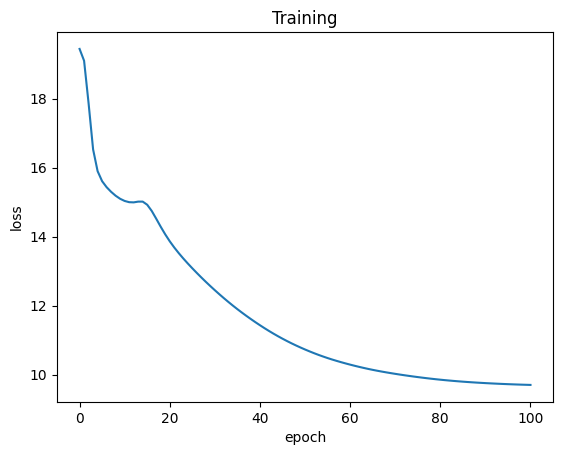

In [6]:
import torch
import numpy as np
import random
import os
import pickle
import time
import matplotlib.pyplot as plt

# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# # If using GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# After setting the seed, continue with your code...

if __name__ == '__main__':
    start = time.perf_counter()
    with open('data/step_4_start_mimiciv_try.pkl', 'rb') as file:
        MIMICtable = pickle.load(file)

    #####################Pengaturan parameter model##############################
    num_epoch = 101  # Number of training cycles
    gamma = 0.99
    beat1 = 0
    beat2 = 0.6
    beta3 = 0.3
    ncv = 5  # nr of crossvalidation runs (each is 80% training / 20% test)Nr of cross-validation runs (80% training / 20% testing each)
    nra = 5
    lr = 1e-4
    beta = [beat1, beat2, beta3]
    icustayidlist = MIMICtable['stay_id']
    icuuniqueids = np.unique(icustayidlist)  # list of unique icustayids from MIMIC unique icustayid list
    reformat5 = MIMICtable.values.copy()
    print('####  generated state  ####')

    # -----------------------Filtered features = 37--------------------------------
    colnorm = ['SOFA', 'age', 'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'Temp_C',
               'Sodium', 'Chloride', 'Glucose', 'Calcium', 'Hb', 'WBC_count', 'Platelets_count',
               'PTT', 'PT', 'Arterial_pH', 'paO2', 'paCO2', 'HCO3', 'Arterial_lactate', 'Shock_Index',
               'PaO2_FiO2', 'cumulated_balance', 'CO2_mEqL', 'Ionised_Ca']
    ##8个指标
    collog = ['SpO2', 'BUN', 'Creatinine', 'SGOT', 'Total_bili', 'INR', 'input_total', 'output_total']

    colnorm = np.where(np.isin(MIMICtable.columns, colnorm))[0]
    collog = np.where(np.isin(MIMICtable.columns, collog))[0]

    scaleMIMIC = np.concatenate([zscore(reformat5[:, colnorm], ddof=1),
                                 zscore(np.log(0.1 + reformat5[:, collog]), ddof=1)], axis=1)

    # scaleMIMIC = zscore(reformat5[:, colnorm], ddof=1)

    train = np.load('data/train_mimiciv.npy')
    validat = np.load('data/validation_mimiciv.npy')
    test = np.load('data/test_mimiciv.npy')

    Xvalidat = scaleMIMIC[validat, :]
    blocsvalidat = reformat5[validat, 0]
    ptidvalidat = reformat5[validat, 1]

    Xtrain = scaleMIMIC[train, :]
    Xtest = scaleMIMIC[test, :]
    blocstrain = reformat5[train, 0]  # Serial number
    bloctest = reformat5[test, 0]
    ptidtrain = reformat5[train, 1]  # Patient number
    ptidtest = reformat5[test, 1]

    # *************************
    RNNstate = Xtrain  # ***

    print('####  Generating Actions  ####')
    nact = nra * nra  # 5*5=25
    iol = MIMICtable.columns.get_loc('input_4hourly')  # Columns entered
    vcl = MIMICtable.columns.get_loc('max_dose_vaso')  # Columns for maximum use of pressurized drugs

    a = reformat5[:, iol].copy()  # IV fluid  Intravenous fluid resuscitation
    a = rankdata(a[a > 0]) / a[a > 0].shape[0]  # excludes zero fluid (will be action 1)Excluding zero fluid, it will be action 1.
    iof = np.floor((a + 0.2499999999) * 4)  # converts iv volume in 4 actions Switching IV volumes in 4 maneuvers
    a = reformat5[:, iol].copy()
    a = np.where(a > 0)[0]  # location of non-zero fluid in big matrix
    io = np.ones((reformat5.shape[0], 1))  # array of ones, by default
    io[a] = (iof + 1).reshape(-1, 1)  # where more than zero fluid given: save actual action
    io = io.ravel()  # Both are essentially trying to bring a multi-dimensional array down to 1 dimension
    # Injections have 5 actions that have been judged by rank #

    vc = reformat5[:, vcl].copy()
    vcr = rankdata(vc[vc != 0]) / vc[vc != 0].size
    vcr = np.floor((vcr + 0.249999999999) * 4)  # converts to 4 bins
    vcr[vcr == 0] = 1
    vc[vc != 0] = vcr + 1
    vc[vc == 0] = 1

    ma1 = np.array(
        [np.median(reformat5[io == 1, iol]), np.median(reformat5[io == 2, iol]), np.median(reformat5[io == 3, iol]),
         np.median(reformat5[io == 4, iol]), np.median(reformat5[io == 5, iol])])  # median dose of drug in all bins
    ma2 = np.array(
        [np.median(reformat5[vc == 1, vcl]), np.median(reformat5[vc == 2, vcl]), np.median(reformat5[vc == 3, vcl]),
         np.median(reformat5[vc == 4, vcl]), np.median(reformat5[vc == 5, vcl])])

    med = np.concatenate([io.reshape(-1, 1), vc.reshape(-1, 1)], axis=1)
    uniqueValues, actionbloc = np.unique(med, axis=0, return_inverse=True)

    actionbloctrain = actionbloc[train]  # ***
    actionblocvalidat = actionbloc[validat]  # ***
    actionbloctest = actionbloc[test]

    ma2Values = ma2[uniqueValues[:, 1].astype('int64') - 1].reshape(-1, 1)
    ma1Values = ma1[uniqueValues[:, 0].astype('int64') - 1].reshape(-1, 1)
    uniqueValuesdose = np.concatenate([ma2Values, ma1Values], axis=1)  # median dose of each bin for all 25 actions

    # =================incentives============================
    print('####  Generate Rewards  ####')
    outcome = 9
    Y90 = reformat5[train, outcome]
    reward_value = 24
    r = np.array([reward_value, -reward_value]).reshape(1, -1)
    r2 = r * (2 * (1 - Y90.reshape(-1, 1)) - 1) # Skor reward

    # -----Incentive function preparation-----------------------------
    SOFA = reformat5[train, 57]  # ***
    R3 = r2[:, 0]
    R4 = (R3 + reward_value) / (2 * reward_value)
    c = 0
    bloc_max = max(blocstrain)

    # ================Build state & & next state sequence lists Generate strategy trajectories=================================
    print(RNNstate.shape[0])

    print('####  Generate trajectory  ####')
    statesize = int(RNNstate.shape[1])
    states = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), statesize))
    actions = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1), dtype=int)
    next_actions = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1), dtype=int)
    rewards = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1))
    next_states = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), statesize))
    done_flags = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1))
    bloc_num = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1))
    blocnum1 = 1

    bloc_num_reward = 0
    for i in range(RNNstate.shape[0] - 1):  # Each line of the cycle
        states[c] = RNNstate[i, :]
        actions[c] = actionbloctrain[i]
        bloc_num[c] = blocnum1
        if (blocstrain[i + 1] == 1):  # end of trace for this patient
            next_states1 = np.zeros(statesize)
            next_actions1 = -1
            done_flags1 = 1
            blocnum1 = blocnum1 + 1
            bloc_num_reward += 1
            reward1 = -beat1 * (SOFA[i]) + R3[i]
            bloc_num_reward = 0
        else:
            next_states1 = RNNstate[i + 1, :]
            next_actions1 = actionbloctrain[i + 1]
            done_flags1 = 0
            blocnum1 = blocnum1
            reward1 = - beat2 * (SOFA[i + 1] - SOFA[i])
            bloc_num_reward += 1
        next_states[c] = next_states1
        next_actions[c] = next_actions1
        rewards[c] = reward1
        done_flags[c] = done_flags1
        c = c + 1
    states[c] = RNNstate[c, :]
    actions[c] = actionbloctrain[c]
    bloc_num[c] = blocnum1

    next_states1 = np.zeros(statesize)
    next_actions1 = -1
    done_flags1 = 1
    blocnum1 = blocnum1 + 1
    bloc_num_reward += 1
    reward1 = -beat1 * (SOFA[c]) + R3[c]

    bloc_num_reward = 0
    next_states[c] = next_states1
    next_actions[c] = next_actions1
    rewards[c] = reward1
    done_flags[c] = done_flags1
    c = c + 1

    bloc_num[c] = blocnum1
    bloc_num = bloc_num[:c, :]
    states = states[: c, :]
    next_states = next_states[: c, :]
    actions = actions[: c, :]
    next_actions = next_actions[: c, :]
    rewards = rewards[: c, :]
    done_flags = done_flags[: c, :]
    bloc_num = np.squeeze(bloc_num)
    actions = np.squeeze(actions)
    rewards = np.squeeze(rewards)
    done_flags = np.squeeze(done_flags)
    batch_size = 16
    state = torch.FloatTensor(states).to(device)
    next_state = torch.FloatTensor(next_states).to(device)
    action = torch.LongTensor(actions).to(device)
    next_action = torch.LongTensor(next_actions).to(device)
    reward = torch.FloatTensor(rewards).to(device)
    done = torch.FloatTensor(done_flags).to(device)
    SOFAS = torch.LongTensor(SOFA).to(device)
    batchs = (state, next_state, action, next_action, reward, done, bloc_num, SOFAS)

# =================Training model, master cycle==================
Y90_validat = reformat5[validat, outcome]
SOFA_validat = reformat5[validat, 57]

# Ensure model is on the correct device
model = EWD3QN(state_dim=37, num_actions=25)

# Instantiating Network Models
record_loss_z = []
record_phys_q = []
record_agent_q = []
# Inisialisasi dengan nilai yang sangat rendah
best_mean_agent_q = -float('inf')
save_dir = 'EWD3QN/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(num_epoch):
    record = model.train(batchs, epoch)
    record_loss_z.append(record)

    record_a = np.array(record_loss_z)
    record_b = np.sum(record_a, axis=1)

    # -------------Validation Sets, Evaluation------------------------------
    uids = np.unique(bloc_num)
    batch_s = ptidvalidat  # Example: unique patient IDs
    batch_user = np.isin(bloc_num, (1, len(batch_s)))
    state_user = state[batch_user, :]
    action_user = action[batch_user]
    next_state_user = next_state[batch_user, :]
    next_action_user = next_action[batch_user]
    reward_user = reward[batch_user]
    done_user = done[batch_user]
    batch = (state_user, next_state_user, action_user,
             next_action_user, reward_user, done_user)

    q_output, agent_actions, phys_actions, Q_value_pro = do_eval(model, batch)

    agent_q = q_output[:, agent_actions]
    phys_q = q_output[:, phys_actions]

    mean_agent_q = torch.mean(agent_q).item()
    mean_phys_q = torch.mean(phys_q).item()

    print(
        f'Epoch {epoch} - Mean agent Q: {mean_agent_q}, Mean phys Q: {mean_phys_q}')

    record_phys_q.append(mean_phys_q)
    record_agent_q.append(mean_agent_q)

    # Save the model if it has the best performance so far
    if mean_agent_q > best_mean_agent_q:
        best_mean_agent_q = mean_agent_q
        best_model_save_path = os.path.join(save_dir, 'best_model.pt')

        model_save_dict = {
            'Q_state_dicts': [q_net.state_dict() for q_net in model.Q_ensemble],
            'Q_target_state_dicts': [q_net.state_dict() for q_net in model.Q_target_ensemble],
            'best_mean_agent_q': best_mean_agent_q
        }
        torch.save(model_save_dict, best_model_save_path)
        print(f'New best model saved with mean agent Q: {best_mean_agent_q}')

    print('Agent actions:', agent_actions)
    print('Physician actions:', phys_actions)


# ===========picture (e.g. of life in the city)=============================
x_length_list = list(range(len(record_b)))
plt.figure()
plt.title('Training')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(x_length_list, record_b)
np.save('loss.npy', record_b)


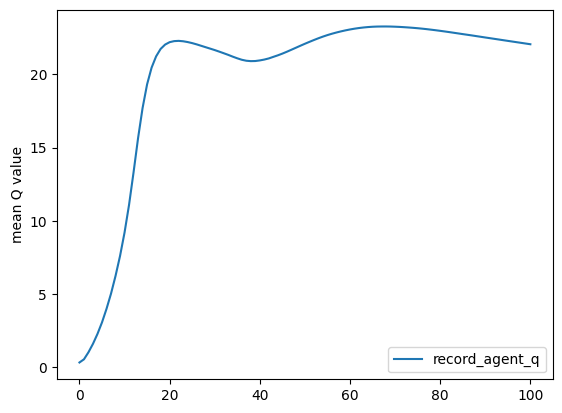

####  Generating test set traces  ####
Time used: 706.503499627


In [7]:
# Convert and save record_agent_q
record_agent_q_np = [
    q.detach().cpu().numpy() if isinstance(q, torch.Tensor) else q
    for q in record_agent_q
]
# Convert the list to a NumPy array
record_agent_q_np = np.array(record_agent_q_np)
agent_length_list = list(range(len(record_agent_q_np)))
plt.plot(agent_length_list, record_agent_q_np, label='record_agent_q')
np.save('mean_agent_q.npy', record_agent_q_np)

# Convert and save record_phys_q

record_phys_q_np = [
    q.detach().cpu().numpy() if isinstance(q, torch.Tensor) else q
    for q in record_phys_q
]
record_phys_q_np = np.array(record_phys_q_np)  # Ensure it's a NumPy array
phys_length_list = list(range(len(record_phys_q_np)))
np.save('mean_phys_q.npy', record_phys_q_np)

# Plot configurations (if needed)
plt.ylabel("mean Q value")
plt.legend()
plt.show()


# =================测试集，评估test set================================================================
Y90_test = reformat5[test, outcome]
SOFA_test = reformat5[test, 57]
do_test(model, Xtest, actionbloctest, bloctest, Y90_test, SOFA_test, reward_value, beta)

elapsed = (time.perf_counter() - start)
print("Time used:", elapsed)
plt.show()